In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import InputLayer, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


2025-05-02 10:01:35.140334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746180095.369838      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746180095.436683      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from xgboost import XGBClassifier

# Data Exploration

In [3]:
data_path = os.path.join('/kaggle/input/covidx-cxr2')
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path,'test')
train_df = pd.read_csv(os.path.join(data_path, 'train.txt'), sep=" ", index_col=None, header=None)
test_df = pd.read_csv(os.path.join(data_path, 'test.txt'), sep=" ", index_col=None, header=None)


In [4]:
val_data_path = os.path.join(data_path,'val')

val_df = pd.read_csv(os.path.join(data_path, 'val.txt'), sep=" ", index_col=None, header=None)


In [5]:
val_df.head()

,0,1,2,3
0,ANON196,CR.1.2.840.113564.1722810170.20200318082923328...,positive,actmed
1,ANON170,CR.1.2.840.113564.1722810170.20200320011259312...,positive,actmed
2,S03044,sub-S03044_ses-E06138_run-1_bp-chest_vp-ap_cr-...,positive,bimcv
3,S03044,sub-S03044_ses-E07712_run-1_bp-chest_vp-ap_cr-...,positive,bimcv
4,S03044,sub-S03044_ses-E06790_run-1_bp-chest_vp-pa_dx-...,positive,bimcv


In [6]:
train_df.head()

,0,1,2,3
0,379,1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg,negative,cohen
1,379,7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg,negative,cohen
2,380,3392dc7d262e28423caca517f98c2e_jumbo.jpeg,negative,cohen
3,380,ec3a480c0926ded74429df416cfb05_jumbo.jpeg,negative,cohen
4,382,a72aeb349a63c79ed24e473c434efe_jumbo.jpg,negative,cohen


In [7]:
train_df.drop(columns = [0,3], axis=1, inplace=True)
test_df.drop(columns = [0,3], axis=1, inplace=True)
val_df.drop(columns = [0,3], axis=1, inplace=True)

In [8]:
train_df = train_df.rename(columns = {1:'image_name', 2:'diagnosis'})
test_df = test_df.rename(columns = {1:'image_name', 2:'diagnosis'})
val_df=val_df.rename(columns = {1:'image_name', 2:'diagnosis'})


In [9]:
train_df.head()


,image_name,diagnosis
0,1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg,negative
1,7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg,negative
2,3392dc7d262e28423caca517f98c2e_jumbo.jpeg,negative
3,ec3a480c0926ded74429df416cfb05_jumbo.jpeg,negative
4,a72aeb349a63c79ed24e473c434efe_jumbo.jpg,negative


In [10]:
train_df.diagnosis.value_counts()

diagnosis
positive    57199
negative    10664
Name: count, dtype: int64

In [11]:
val_df.diagnosis.value_counts()

diagnosis
positive    4241
negative    4232
Name: count, dtype: int64

In [12]:
train_df.isnull().sum()

image_name    0
diagnosis     0
dtype: int64

In [13]:
train_df.duplicated().sum()

0

In [14]:
val_df.isnull().sum()

image_name    0
diagnosis     0
dtype: int64

In [15]:
val_df.duplicated().sum()

0

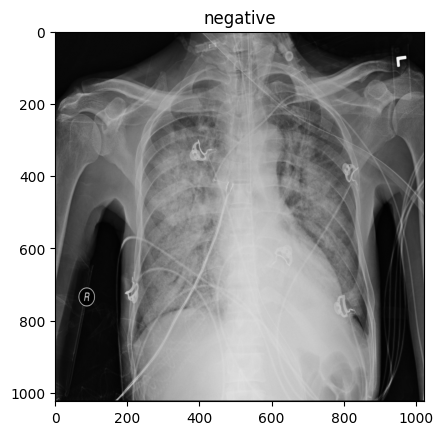

(1024, 1024, 3)

In [41]:
rand_indx = np.random.randint(0,len(train_df),1)[0]
img = cv2.imread(os.path.join(train_data_path, train_df.image_name[rand_indx]))
plt.imshow(img/255)
plt.title(train_df.diagnosis[rand_indx])
plt.show()
img.shape


In [17]:
from sklearn.model_selection import train_test_split

In [18]:
train_df, df_test = train_test_split(train_df, test_size=0.2, stratify=train_df['diagnosis'], random_state=42)

In [19]:
df_majority = train_df[train_df['diagnosis'] == 'positive']
df_minority = train_df[train_df['diagnosis'] == 'negative']

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=len(df_majority), 
                                 random_state=42)

train_df = pd.concat([df_majority, df_minority_upsampled])
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [20]:
train_df.diagnosis.value_counts()

diagnosis
positive    45759
negative    45759
Name: count, dtype: int64

In [21]:
df_test.diagnosis.value_counts()

diagnosis
positive    11440
negative     2133
Name: count, dtype: int64

In [22]:
def custom_preprocess(img):
    img = img.astype(np.uint8)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)
    mask = cv2.medianBlur(mask, 5)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    img = cv2.bitwise_and(img, mask)

    return img.astype(np.float32) / 255.0


In [23]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    preprocessing_function=custom_preprocess,
    rotation_range=15, zoom_range=0.1, horizontal_flip=True,
    width_shift_range=0.05, height_shift_range=0.05
).flow_from_dataframe(
    dataframe=train_df, directory=train_data_path,
    x_col='image_name', y_col='diagnosis',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=True
)

val_gen = ImageDataGenerator(
    preprocessing_function=custom_preprocess
).flow_from_dataframe(
    dataframe=val_df, directory=val_data_path,
    x_col='image_name', y_col='diagnosis',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False
)


Found 91518 validated image filenames belonging to 2 classes.
Found 8473 validated image filenames belonging to 2 classes.


In [24]:
base_model = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)


I0000 00:00:1746180334.306949      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746180334.307762      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
def extract_features_in_batches(generator, model):
    features, labels = [], []
    for i in tqdm(range(len(generator))):
        x_batch, y_batch = generator[i]
        f_batch = model.predict(x_batch, verbose=0)
        features.append(f_batch)
        labels.append(y_batch)
    return np.vstack(features), np.hstack(labels)


In [26]:

features_train, y_train = extract_features_in_batches(train_gen, feature_extractor)
features_val, y_val = extract_features_in_batches(val_gen, feature_extractor)

  0%|          | 0/2860 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1746180337.800848      99 service.cc:148] XLA service 0x7f2358109170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746180337.801889      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746180337.801912      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746180337.943288      99 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746180348.225132      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 265/265 [04:26<00:00,  1.01s/it]


In [27]:
test_datagen = ImageDataGenerator(preprocessing_function=custom_preprocess)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=train_data_path,
    x_col='image_name',
    y_col='diagnosis',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 13573 validated image filenames belonging to 2 classes.


In [34]:
print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_test:", np.unique(y_test))

Unique labels in y_train: [0. 1.]
Unique labels in y_test: [0. 1.]


In [28]:
features_test, y_test = extract_features_in_batches(test_gen, feature_extractor)

100%|██████████| 425/425 [06:36<00:00,  1.07it/s]


In [29]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(features_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [30]:
y_pred_train = xgb.predict(features_train)
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))

Train Accuracy: 0.8657531851657597


In [31]:
print("Validation Accuracy:", accuracy_score(y_val, xgb.predict(features_val)))
print("Test Accuracy:", accuracy_score(y_test, xgb.predict(features_test)))

Validation Accuracy: 0.8601439867815414
Test Accuracy: 0.8964856700803064


In [32]:
y_pred_test = xgb.predict(features_test)
y_proba_test = xgb.predict_proba(features_test)[:, 1]

print("\n VGG16 + XGBoost Test Results:")
print(classification_report(y_test, y_pred_test))
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("AUC Score:", roc_auc_score(y_test, y_proba_test))



 VGG16 + XGBoost Test Results:
              precision    recall  f1-score   support

         0.0       0.64      0.79      0.71      2133
         1.0       0.96      0.92      0.94     11440

    accuracy                           0.90     13573
   macro avg       0.80      0.85      0.82     13573
weighted avg       0.91      0.90      0.90     13573

Accuracy: 0.8964856700803064
AUC Score: 0.9333708309974134


# Explainability

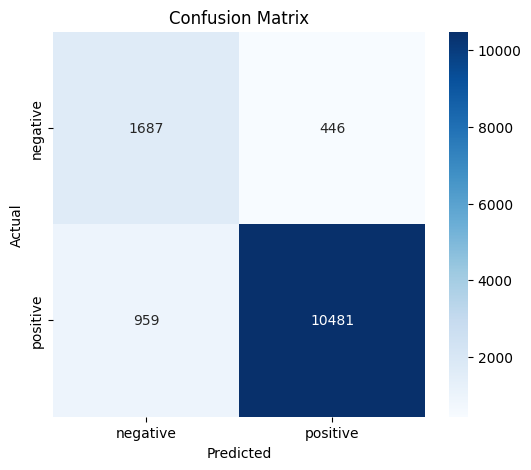

In [33]:
import seaborn as sns


class_labels = ['negative', 'positive']
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


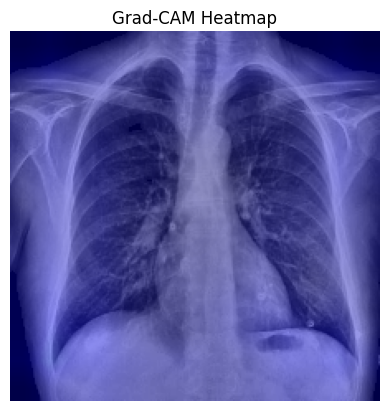

In [38]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = tf.reduce_max(predictions)

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap(heatmap, img, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, colormap)
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    return overlay

def load_and_preprocess_image(img_path):
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
    img_resized = cv2.resize(img_rgb, (224, 224))
    img_clahe = custom_preprocess(img_resized)
    return np.expand_dims(img_clahe, axis=0)

img_path = "/kaggle/input/covidx-cxr2/train/000001-3.jpg"
img_array = load_and_preprocess_image(img_path)

heatmap = make_gradcam_heatmap(img_array, base_model, "block5_conv3")
overlay = overlay_heatmap(heatmap, (img_array[0] * 255).astype(np.uint8))
plt.imshow(overlay)
plt.axis('off')
plt.title("Grad-CAM Heatmap")
plt.show()

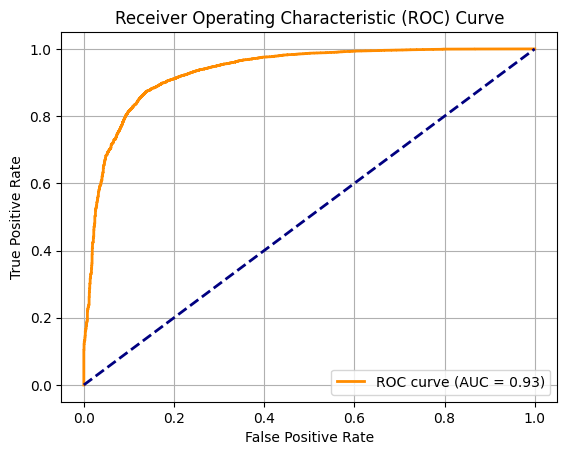

In [39]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


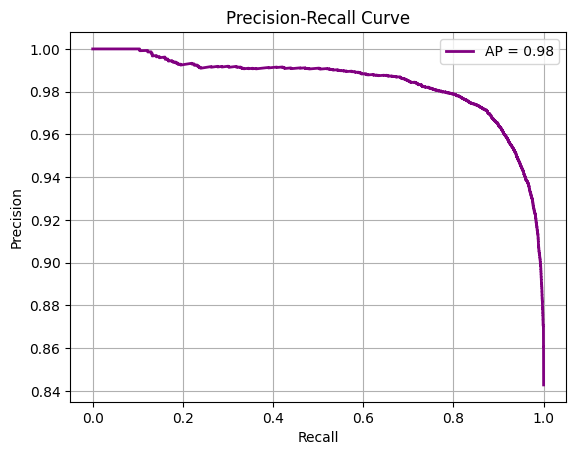

In [40]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
ap_score = average_precision_score(y_test, y_proba_test)

plt.figure()
plt.plot(recall, precision, lw=2, color='purple', label=f'AP = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()
